In [1]:
import numpy as np
from astropy.io import fits
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
#image_path = '/sps/lsst/groups/auxtel/data/raw_ncsa/'+obs_date+'/'
image_path = '/sps/lsst/groups/auxtel/data/raw_ncsa/{0}/{1}/'
image_label = 'AT_O_{2}_{3}_R00_S00.fits'
image_name = os.path.join(image_path,image_label)
print(image_name)

/sps/lsst/groups/auxtel/data/raw_ncsa/{0}/{1}/AT_O_{2}_{3}_R00_S00.fits


In [3]:
list_path = 'output_lists/'
outdir_base = 'output_fits/'
if os.path.exists(outdir_base)==False:
    os.mkdir(outdir_base)

In [4]:
bias_label = 'bias_ids_{0}.txt'
flat_label = 'flat_ids_{0}_{1}.txt'

In [5]:
date_bias = '20220608'

In [21]:
filters = ['FELH0600','BG40','SDSSg']
#filters = ['FELH0600']
date_dict = {'SDSSg':'20220608','SDSSr':'','empty':'','BG40':'20220608','FELH0600':'20220608'}

In [7]:
#date_flat = '20220608'

In [8]:
calc_master_bias = True
calc_master_flat = True

# Fix detector parameters 

In [9]:
num_segments = 16

In [10]:
segment = 0

In [11]:
hprescan = 3
hoverscan = 64
voverscan = 48

# Check that things work for flats 

In [12]:
filter0 = 'SDSSg'
date0 = date_dict[filter0]

In [13]:
flat_ids_file0 = open(os.path.join(list_path,flat_label.format(date0,filter0))).readlines()
flat_ids0 = []
for line in flat_ids_file0:
    #print(line)
    flat_ids0.append(line.split('\n')[0])
print(flat_ids0)

['000054', '000059', '000053', '000062', '000049', '000045', '000050', '000060', '000056', '000061', '000046', '000063', '000064', '000052', '000065', '000051', '000047', '000055', '000048', '000057', '000058']


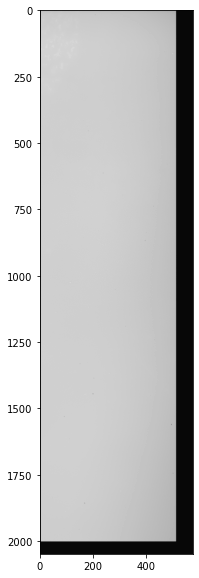

In [14]:
f0 = fits.open(image_name.format(date0,flat_ids0[0],date0,flat_ids0[0]))
assert (f0[0].header['IMGTYPE']=='FLAT')
data0 = f0[16].data
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)

ax.imshow(data0,cmap="gray",norm=LogNorm())
plt.show()

In [15]:
print(data0[1500,:][:20])
print(np.mean(data0[1500,:][:20]))
print(data0[2001,:][:20])
print(np.mean(data0[2001,:][:20]))

[14950 14040 14805 80641 79884 79909 80678 79752 79911 80025 80294 80606
 80601 79956 79983 79892 80029 80426 80528 80907]
70390.85
[14954 14044 14766 14955 14927 14979 14927 14954 14969 14946 14968 14933
 14980 14945 14963 14954 14955 14966 14947 14965]
14899.85


In [16]:
len(data0.ravel())

1179648

In [17]:
mu = np.average(data0.ravel())
std = np.std(data0.ravel())

# Create master (median) bias from individual biases 

In [18]:
if calc_master_bias==True:
    bias_ids_file = open(os.path.join(list_path,bias_label.format(date_bias))).readlines()
    bias_ids = []
    for line in bias_ids_file:
        bias_ids.append(line.split('\n')[0])
    bias_ids = np.array(bias_ids)
    print(bias_ids)
    
    new_hdul = fits.HDUList()
    hdu1 = fits.PrimaryHDU()
    for seg in range(num_segments):
        bias_list = []
        #print(seg)
        hdu2 = fits.ImageHDU()
        for num,i in enumerate(bias_ids):
            image_file = image_name.format(date_bias,str(i),date_bias,str(i))
            f = fits.open(image_file)
            assert (f[0].header['IMGTYPE']=='BIAS')
            #print('Exposure time = ', f[0].header['EXPTIME'])
            if num == 0 and seg == 0:
                hdu1.header = f[0].header
                hdu1.header['PIXSTAT'] = 'Median'
                hdu1.header['IMGRANGE'] = (int(np.min(bias_ids.astype('float'))),int(np.max(bias_ids.astype('float'))))
                hdu1.data = f[0].data
                new_hdul.append(hdu1) 
            data = f[num_segments-seg].data
            #print(data.shape)
            bias_list.append(data)
            f.close()
        bias_array = np.array(bias_list)
        print(bias_array.shape)
        median_bias = np.median(bias_array,axis=0)
        print(median_bias.shape)
        hdu2.header = f[num_segments-seg].header
        hdu2.data = median_bias
        new_hdul.append(hdu2)
        print('----------')
    print(len(new_hdul))
    outdir_bias = os.path.join(outdir_base,date_bias+'_run/')
    if os.path.exists(outdir_bias)==False:
        os.mkdir(outdir_bias)
    new_hdul.writeto(outdir_bias+'master_bias_median_{0}_{1}_{2}.fits'.format(date_bias,int(np.min(bias_ids.astype('float'))),int(np.max(bias_ids.astype('float')))), overwrite=True)
else:
    bias_ids_file = open(os.path.join(list_path,bias_label.format(date_bias))).readlines()
    bias_ids = []
    for line in bias_ids_file:
        bias_ids.append(line.split('\n')[0])
    bias_ids = np.array(bias_ids)
    print(bias_ids)
    outdir_bias = os.path.join(outdir_base,date_bias+'_run/')
    if os.path.exists(outdir_bias)==False:
        os.mkdir(outdir_bias)

['000123' '000112' '000017' '000133' '000016' '000009' '000117' '000114'
 '000118' '000121' '000007' '000018' '000010' '000024' '000109' '000119'
 '000134' '000126' '000011' '000127' '000015' '000135' '000108' '000023'
 '000136' '000131' '000128' '000008' '000122' '000012' '000130' '000022'
 '000005' '000132' '000124' '000137' '000120' '000013' '000125' '000014'
 '000113' '000110' '000020' '000001' '000111' '000115' '000019' '000021'
 '000006' '000129']


In [19]:
try:
    master_bias = fits.open(outdir_bias+'master_bias_median_{0}_{1}_{2}.fits'.format(date_bias,int(np.min(bias_ids.astype('float'))),int(np.max(bias_ids.astype('float')))))
except:
    print('No master bias found. Create it before continuing')

# Loop over filters and over CCD segments to create master (median) flats 

In [20]:
if calc_master_flat==True:
    flat_ids_dict = {}
    for filter in filters:
        date_flat = date_dict[filter]
        flat_ids_file = open(os.path.join(list_path,flat_label.format(date_flat,filter))).readlines()
        flat_ids_ = []
        for line in flat_ids_file:
            flat_ids_.append(line.split('\n')[0])
        flat_ids_ = np.array(flat_ids_)
        flat_ids_dict[filter] = flat_ids_
    
    median_dict = {}
    for filter in filters:
        print('#######################################'+filter)
        #data_array = np.array([])
        #data_list = []
        flat_ids = flat_ids_dict[filter]
        print(flat_ids)
        for i in flat_ids:
            #print(i)
            image_file = image_name.format(date_dict[filter],str(i),date_dict[filter],str(i))
            f = fits.open(image_file)
            shape0 = f[1].data.shape
        
            for seg in range(1,9):
                #print(seg,f[seg].header['EXTNAME'])
                data_ = f[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]-master_bias[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
                data_ = np.flip(data_,axis=1)
                if seg==1:
                    data0 = data_
                else:
                    data0 = np.concatenate((data0,data_),axis=1)
            for seg in range(9,num_segments+1):
                seg = num_segments+9-seg
                #print(seg,f[seg].header['EXTNAME'])
                data_ = f[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]-master_bias[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
                data_ = np.flip(data_,axis=0)
                data_ = np.flip(data_,axis=1)
                if seg==16:
                    data1 = data_
                else:
                    data1 = np.concatenate((data1,data_),axis=1)
            data_ccd = np.concatenate((data0,data1),axis=0)
            median_dict[(filter,i)] = np.median(data_ccd)
        

#######################################FELH0600
['000156' '000159' '000094' '000095' '000089' '000093' '000155' '000092'
 '000099' '000090' '000091' '000098' '000096' '000107' '000166' '000161'
 '000158' '000154' '000105' '000153' '000102' '000162' '000167' '000160'
 '000103' '000157' '000164' '000104' '000101' '000097' '000087' '000106'
 '000100' '000163' '000088' '000165']
#######################################BG40
['000069' '000070' '000080' '000077' '000082' '000075' '000083' '000067'
 '000078' '000074' '000081' '000066' '000086' '000068' '000076' '000071'
 '000072' '000084' '000085' '000073' '000079']
#######################################SDSSg
['000054' '000059' '000053' '000062' '000049' '000045' '000050' '000060'
 '000056' '000061' '000046' '000063' '000064' '000052' '000065' '000051'
 '000047' '000055' '000048' '000057' '000058']


KeyboardInterrupt: 

In [23]:
if calc_master_flat==True:
    for filter in filters:
        print('#######################################'+filter)
        #flat_list = []
        date_flat = date_dict[filter]
        flat_ids = flat_ids_dict[filter]
        
        new_hdul = fits.HDUList()
        hdu1 = fits.PrimaryHDU()
        for seg in range(num_segments):
            flat_list = []
            hdu2 = fits.ImageHDU()
            for num,i in enumerate(flat_ids):
                image_file = image_name.format(date_dict[filter],str(i),date_dict[filter],str(i))
                f = fits.open(image_file)
                assert (f[0].header['IMGTYPE']=='FLAT')
                if num == 0 and seg == 0:
                    hdu1.header = f[0].header
                    hdu1.header['PROCESS'] = 'Flat-Master_bias'
                    hdu1.header['PIXSTAT'] = 'Median'
                    hdu1.header['IMGRANGE'] = (int(np.min(flat_ids.astype('float'))),int(np.max(flat_ids.astype('float'))))
                    hdu1.data = f[0].data
                    new_hdul.append(hdu1)
                data_i = f[num_segments-seg].data 
                data_i_bias = np.zeros(data_i.shape)
                data_i_bias[shape0[0]-voverscan:,:] = data_i[shape0[0]-voverscan:,:]
                data_i_bias[:,:hprescan] = data_i[:,:hprescan]
                data_i_bias[:,shape0[1]-hoverscan:] = data_i[:,shape0[1]-hoverscan:]
                data_i_bias[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan] = data_i[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]-master_bias[num_segments-seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
                data_i_norm = np.zeros(data_i_bias.shape)
                data_i_norm[shape0[0]-voverscan:,:] = data_i[shape0[0]-voverscan:,:]
                data_i_norm[:,:hprescan] = data_i[:,:hprescan]
                data_i_norm[:,shape0[1]-hoverscan:] = data_i[:,shape0[1]-hoverscan:]
                data_i_norm[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan] = data_i_bias[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]/median_dict[(filter,i)]
                
                flat_list.append(data_i_norm)
                f.close()
            flat_array = np.array(flat_list)
            print(flat_array.shape)
            median_flat = np.median(flat_array,axis=0)
            print(median_flat.shape)
            hdu2.header = f[num_segments-seg].header
            hdu2.data = median_flat
            new_hdul.append(hdu2)
            print('----------')
        print(len(new_hdul))
        outdir_flat = os.path.join(outdir_base,date_flat+'_run/')
        if os.path.exists(outdir_flat)==False:
            os.mkdir(outdir_flat)
        new_hdul.writeto(outdir_flat+'master_flat_median_{0}_{1}_{2}_{3}_renormalised.fits'.format(date_flat,filter,int(np.min(flat_ids.astype('float'))),int(np.max(flat_ids.astype('float')))), overwrite=True)


#######################################FELH0600
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
(36, 2048, 576)
(2048, 576)
----------
17


# TESTS 

In [ ]:
fred = fits.open(outdir_flat+'master_flat_median_20220608_SDSSg_45_65_renormalised.fits')
fred.info()

In [ ]:
shape0 = fred[1].data.shape
print(shape0)

In [ ]:
for seg in range(1,9):
    print(seg,fred[seg].header['EXTNAME'])
    data_ = fred[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    data_ = np.flip(data_,axis=1)
    if seg==1:
        dred0 = data_
    else:
        dred0 = np.concatenate((dred0,data_),axis=1)
for seg in range(9,num_segments+1):
    seg = num_segments+9-seg
    print(seg,fred[seg].header['EXTNAME'])
    data_ = fred[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    data_ = np.flip(data_,axis=0)
    data_ = np.flip(data_,axis=1)
    if seg==16:
        dred1 = data_
    else:
        dred1 = np.concatenate((dred1,data_),axis=1)
data0red = np.concatenate((dred0,dred1),axis=0)

In [ ]:
plt.hist(data0red.ravel(),bins=100,range=(0.8,1.2))

In [ ]:
data0red[200,400:410]

In [ ]:
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.imshow(data0red,cmap="gray",vmin=0.8,vmax=1.2)#,norm=LogNorm())fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111)
ax.imshow(data0red,cmap="gray",vmin=0.8,vmax=1.2)#,norm=LogNorm())

In [ ]:
np.median(data0red.ravel())

In [ ]:
print(np.min(data0red.ravel()),np.max(data0red.ravel()))

In [ ]:
median_vec = []
for seg in range(1,num_segments+1):
    data_ = fred[seg].data[:shape0[0]-voverscan,hprescan:shape0[1]-hoverscan]
    plt.hist(data_.ravel(),bins=100,range=(0.95,1.05),histtype='step')
    median_vec.append(np.median(data_.ravel()))
plt.grid()

In [ ]:
median_vec = np.array(median_vec)
plt.plot(np.arange(num_segments),median_vec)
plt.grid()